In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import preprocessing

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

In [3]:
df_customer = pd.read_csv("E:\Certifications\Machine Learning & Data Science\Kalbe\data\Customer.csv", delimiter = ';')
df_product = pd.read_csv("E:\Certifications\Machine Learning & Data Science\Kalbe\data\Product.csv", delimiter = ';')
df_store = pd.read_csv("E:\Certifications\Machine Learning & Data Science\Kalbe\data\Store.csv", delimiter = ';')
df_transaction = pd.read_csv("E:\Certifications\Machine Learning & Data Science\Kalbe\data\Transaction.csv", delimiter = ';')

## Data Cleansing

### df_customer

In [4]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      447 non-null    int64 
 1   Age             447 non-null    int64 
 2   Gender          447 non-null    int64 
 3   Marital Status  444 non-null    object
 4   Income          447 non-null    object
dtypes: int64(3), object(2)
memory usage: 17.6+ KB


In [5]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [6]:
df_customer.fillna(method='ffill', inplace=True)

In [7]:
df_customer.duplicated().sum()

0

In [8]:
df_customer['Income'] = df_customer['Income'].apply(lambda x: x.replace(',', '.')).astype(float)

In [9]:
df_product

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200
5,P6,Cashew,18000
6,P7,Coffee Candy,9400
7,P8,Oat,16000
8,P9,Yoghurt,10000
9,P10,Cheese Stick,15000


In [10]:
df_store

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"
5,6,Lingga,Lingga,Modern Trade,"-5,135399","119,42379"
6,7,Buana Indah,Buana,General Trade,"3,316694","114,590111"
7,8,Sinar Harapan,Harapan Baru,General Trade,"5,54829","95,323753"
8,9,Lingga,Lingga,Modern Trade,"-3,654703","128,190643"
9,10,Harapan Baru,Harapan Baru,General Trade,"3,597031","98,678513"


In [11]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


In [12]:
df_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


In [13]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

C:\Users\ariju\AppData\Local\Temp\ipykernel_12944\794535102.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])


## Merge Data

In [14]:
df_merge = pd.merge(df_transaction, df_customer, on=['CustomerID'])
df_merge = pd.merge(df_merge, df_product, on=['ProductID'])
df_merge = pd.merge(df_merge, df_store, on=['StoreID'])
df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price_x,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_y,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,Single,4.74,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,Married,9.94,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"


In [15]:
df_merge = df_merge.drop(columns=['Price_y'])

In [16]:
df_merge = df_merge.rename(columns={'Price_x' : 'Price'})

In [17]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  5020 non-null   object        
 11  Income          5020 non-null   float64       
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

## Regression Model (Time Series)

In [18]:
df_reg = df_merge.groupby(['Date']).agg({
    'Qty' : 'sum'
})

In [19]:
df_reg

,Qty
Date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


<Axes: title={'center': 'Daily Sales'}, xlabel='Date', ylabel='Total Qty'>

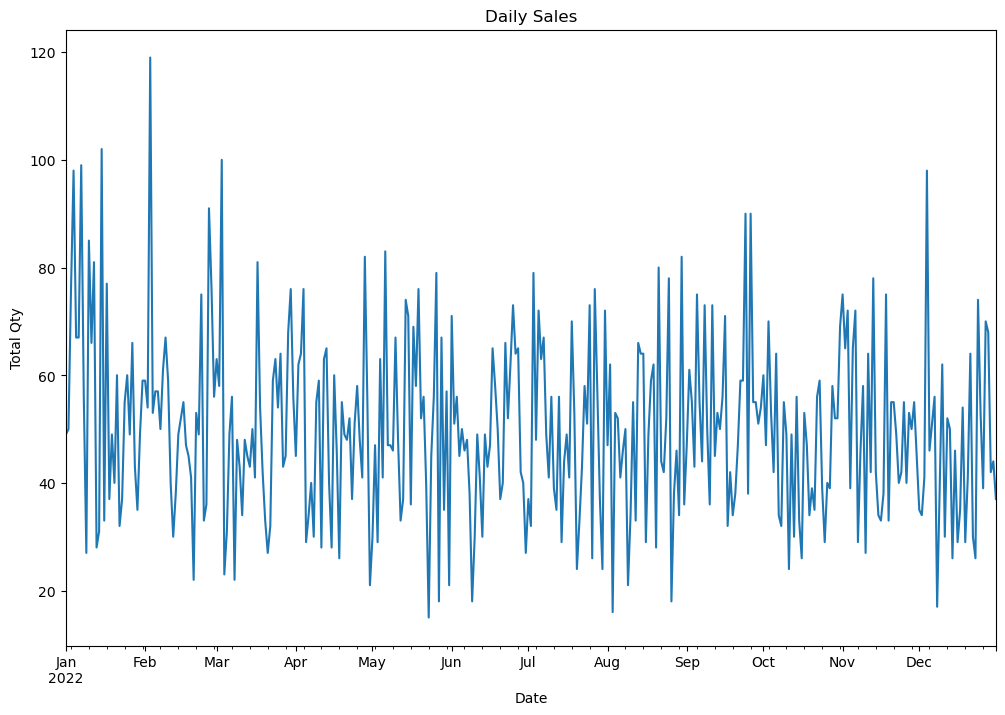

In [20]:

# plot qty sales in a year
df_reg.plot(figsize=(12,8), title='Daily Sales', xlabel='Date', ylabel='Total Qty', legend=False)

In [21]:
x_train = df_reg[:int(0.8*(len(df_reg)))].reset_index()
x_test = df_reg[int(0.8*(len(df_reg))):].reset_index()

In [22]:
x_train

,Date,Qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
287,2022-10-15,33
288,2022-10-16,26
289,2022-10-17,53
290,2022-10-18,47


In [23]:
x_test

,Date,Qty
0,2022-10-20,39
1,2022-10-21,35
2,2022-10-22,56
3,2022-10-23,59
4,2022-10-24,39
...,...,...
68,2022-12-27,70
69,2022-12-28,68
70,2022-12-29,42
71,2022-12-30,44


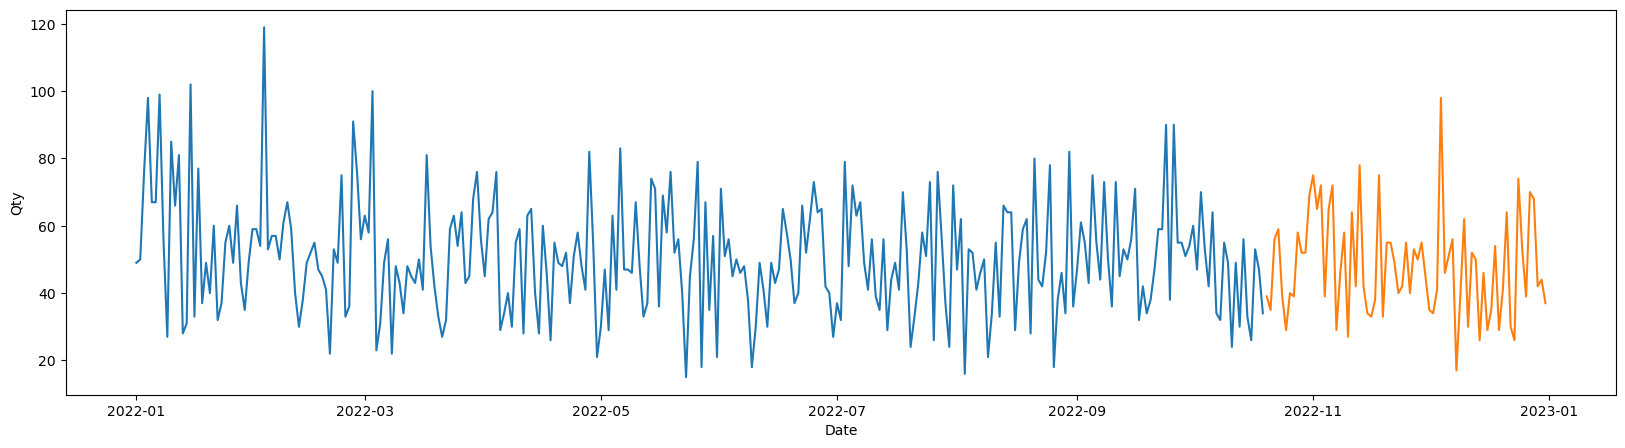

In [25]:
plt.figure(figsize = (20,5))
sns.lineplot(data=x_train, x=x_train['Date'], y=x_train['Qty']);
sns.lineplot(data=x_test, x=x_test['Date'], y=x_test['Qty']);

In [26]:
def rmse(y_actual,y_pred):
    print(f'RMSE value {(mean_squared_error(y_actual, y_pred)**0.5)}')
def eval(y_actual, y_pred):
    rmse(y_actual,y_pred)
    print(f'MAE value {mean_absolute_error(y_actual, y_pred)}')

C:\Users\ariju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ariju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\ariju\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RMSE value 18.374679057234662
MAE value 13.901813924970963


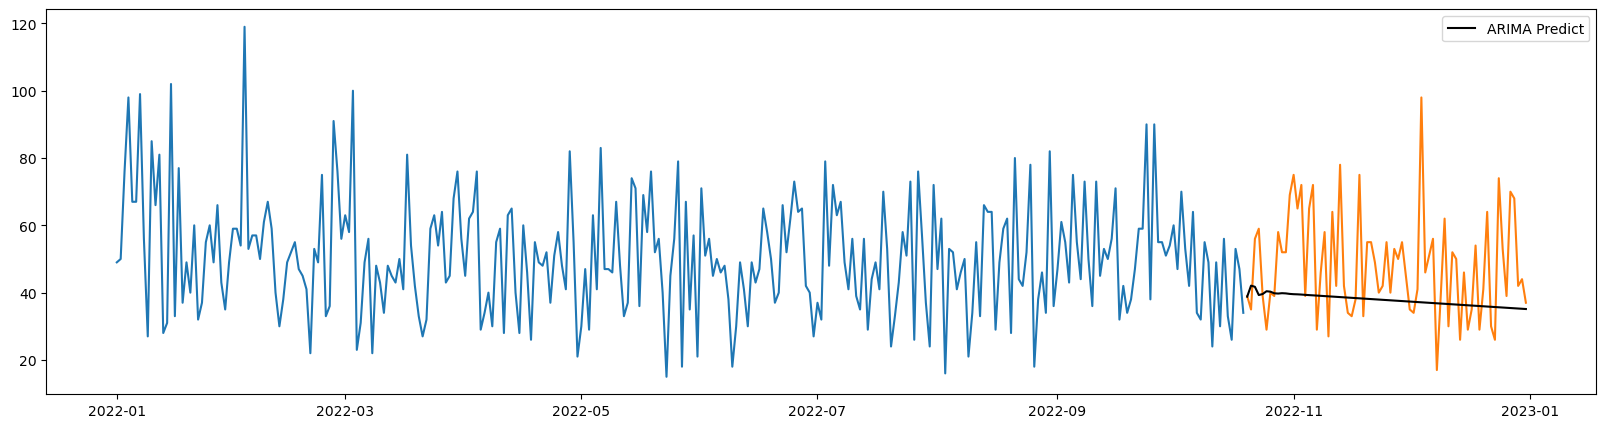

In [27]:
train = x_train.set_index('Date')
test = x_test.set_index('Date')

y = train['Qty']

ARIMAmodel = ARIMA(y,order = (4, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['predictions']
eval(test['Qty'], y_pred_out)

plt.figure(figsize=(20,5))
plt.plot(train['Qty'])
plt.plot(test['Qty'])
plt.plot(y_pred_out, color = 'black', label = 'ARIMA Predict')
plt.legend()


In [28]:
y_pred_df

,lower Qty,upper Qty,predictions
Date,,,
2022-10-20,3.003298,74.595636,38.799467
2022-10-21,5.806563,78.347398,42.076981
2022-10-22,4.359602,79.117895,41.738749
2022-10-23,0.250215,78.330781,39.290498
2022-10-24,-2.345163,81.521172,39.588004
...,...,...,...
2022-12-27,-81.508698,152.366762,35.429032
2022-12-28,-82.518105,153.228368,35.355132
2022-12-29,-83.524446,154.086908,35.281231


In [29]:
df_qty =test['Qty']
df_qty_pred = y_pred_df['predictions']
df_qty_pred.shape

(73,)

In [30]:
myDict = {
    'Data Real' : df_qty, 'Prediksi' : df_qty_pred
}

In [31]:
df_predict = pd.DataFrame(myDict)
df_predict

,Data Real,Prediksi
Date,,
2022-10-20,39,38.799467
2022-10-21,35,42.076981
2022-10-22,56,41.738749
2022-10-23,59,39.290498
2022-10-24,39,39.588004
...,...,...
2022-12-27,70,35.429032
2022-12-28,68,35.355132
2022-12-29,42,35.281231
